In [1]:
import os
os.chdir('../data/')

import matplotlib.pyplot as plt
import numpy as np

import load_data
import feature_engineering
import utils

In [2]:
GPR_PATH = 'synthetic/gpr.sgy'
SIM_PATH = 'synthetic/gpr_Similarity1.sgy'
ENERGY_PATH = 'synthetic/gpr_Energy1.sgy'
INTFREQ_PATH = 'synthetic/gpr_IntFreq.sgy'
INTPHASE_PATH = 'synthetic/gpr_IntPhase.sgy'
HILBERT_PATH = 'synthetic/gpr_HilbertTrace1.sgy'

In [3]:
file_paths = [GPR_PATH, SIM_PATH, ENERGY_PATH, INTFREQ_PATH, INTPHASE_PATH, HILBERT_PATH]

In [4]:
gpr = load_data.segy_to_numpy(load_data.load_segy(GPR_PATH))
sim = load_data.segy_to_numpy(load_data.load_segy(SIM_PATH))
en = load_data.segy_to_numpy(load_data.load_segy(ENERGY_PATH))
intfreq = load_data.segy_to_numpy(load_data.load_segy(INTFREQ_PATH))
intphase = load_data.segy_to_numpy(load_data.load_segy(INTPHASE_PATH))
hilb = load_data.segy_to_numpy(load_data.load_segy(HILBERT_PATH))

In [5]:
sample_size = 16
gpr = utils.clip(gpr, sample_size)
number_of_rows = gpr.shape[0]

In [6]:
def pad_attribute(attribute, number_of_rows = number_of_rows):
    
    missing_rows = int((number_of_rows - attribute.shape[0]) / 2)
    if missing_rows > 0:
        attribute = np.pad(
            attribute, ((missing_rows, missing_rows), (0, 0)), constant_values=0
        )
    
    return attribute

In [7]:
sim = pad_attribute(sim)
en = pad_attribute(en)
intfreq = pad_attribute(intfreq)
intphase = pad_attribute(intphase)
hilb = pad_attribute(hilb)

In [8]:
sim.shape, en.shape, intfreq.shape, intphase.shape, hilb.shape

((1872, 3001), (1872, 3001), (1873, 3001), (1875, 3001), (1872, 3001))

In [9]:
sim = utils.clip(sim, 16)
en = utils.clip(en, 16)
intfreq = utils.clip(intfreq, 16)
intphase = utils.clip(intphase, 16)
hilb = utils.clip(hilb, 16)

In [10]:
sim.shape, en.shape, intfreq.shape, intphase.shape, hilb.shape

((1872, 2992), (1872, 2992), (1872, 2992), (1872, 2992), (1872, 2992))

In [11]:
hilb_sim = np.divide(hilb, sim)
print(np.isnan(hilb_sim).sum())
hilb_sim = np.nan_to_num(hilb_sim, nan=0, posinf=0, neginf=0)

65824


/tmp/ipykernel_4330/3392601266.py:1: RuntimeWarning: divide by zero encountered in true_divide
  hilb_sim = np.divide(hilb, sim)
/tmp/ipykernel_4330/3392601266.py:1: RuntimeWarning: invalid value encountered in true_divide
  hilb_sim = np.divide(hilb, sim)


In [12]:
data = np.stack([gpr, sim, en, intfreq, intphase, hilb_sim], axis = -1)

In [13]:
data.shape

(1872, 2992, 6)

In [14]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)




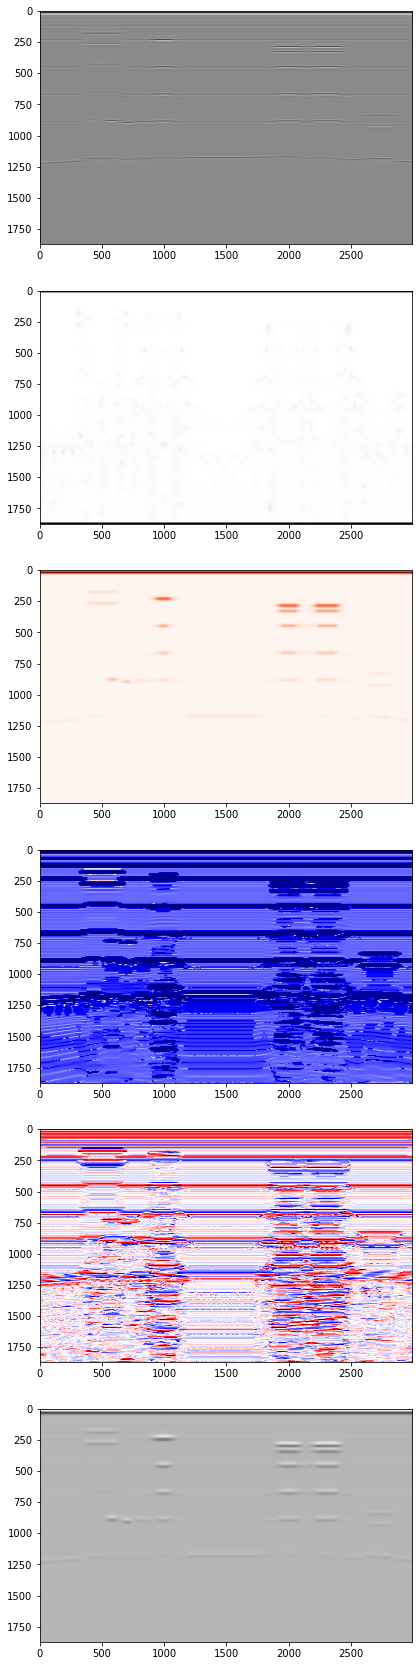

In [15]:
fig, ax = plt.subplots(6, 1, figsize = (10, 30))

cmap_list = [
     'gray', #GPR Section
     'gray', #Similarity
     'Reds', #Energy
     'seismic', #Inst Frequency
     'seismic', #Inst Phase
     grayscale_cmap('RdBu'), #Hilb/Sim             
]

for index, _ in enumerate(ax):
    _.imshow(data[:, :, index], cmap = cmap_list[index])

In [16]:
n_traces = data.shape[1]

In [22]:
step = int(n_traces/16)

In [35]:
start = 0

samples = {}
n_samples = 16

for n_sample in range(n_samples):
    print(start, start + step)
    print(data[:, start:start + step, :].shape)
    samples[n_sample] = data[:, start:start + step, :]
    start += step

0 187
(1872, 187, 6)
187 374
(1872, 187, 6)
374 561
(1872, 187, 6)
561 748
(1872, 187, 6)
748 935
(1872, 187, 6)
935 1122
(1872, 187, 6)
1122 1309
(1872, 187, 6)
1309 1496
(1872, 187, 6)
1496 1683
(1872, 187, 6)
1683 1870
(1872, 187, 6)
1870 2057
(1872, 187, 6)
2057 2244
(1872, 187, 6)
2244 2431
(1872, 187, 6)
2431 2618
(1872, 187, 6)
2618 2805
(1872, 187, 6)
2805 2992
(1872, 187, 6)


In [39]:
train_samples = np.random.choice(list(samples.keys()), size=int(0.8*n_samples), replace=False)

test_samples = set(samples.keys()) - set(train_samples)

In [40]:
train_samples, test_samples

(array([13,  0, 14,  4,  8,  2,  5,  9, 11,  7, 15,  1]), {3, 6, 10, 12})

In [49]:
train_data = np.empty(shape=(0, 0, 0),)

In [54]:
train_data = np.concatenate([samples[sample_number] for sample_number in train_samples])
test_data = np.concatenate([samples[sample_number] for sample_number in test_samples])

In [56]:
train_data.shape, test_data.shape

((22464, 187, 6), (7488, 187, 6))

In [42]:
from sklearn import preprocessing

In [43]:
transformer = preprocessing.PowerTransformer(method='yeo-johnson')

In [58]:
transformers = {}

for channel_number in range(train_data.shape[-1]):
    transformer = preprocessing.PowerTransformer(method='yeo-johnson')
    train_data[:, :, channel_number] = transformer.fit_transform(train_data[:, :, channel_number])
    test_data[:, :, channel_number] = transformer.transform(test_data[:, :, channel_number])  
    transformers[channel_number] = transformer